In [10]:
from util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle

from scipy import stats
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from joblib import dump, load

In [2]:
data_log, data_dash = get_data_frames()
result_total, labels = get_data_concated(data_log, data_dash)

### Random Florest Model

In [10]:
def train_rf_model(features_train: pd.DataFrame, labels_train: pd.Series):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features_train,
        np.ravel(labels_train),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=80,
        min_samples_split=5,
        min_samples_leaf=2,
        bootstrap=True,
        verbose=1,
        max_features='sqrt',
        n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        rf_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )

    avg_cv_score = np.mean(cv_scores)

    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf = rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = mae_rf / np.mean(y_validation)

    feature_importances = rf_model.feature_importances_
    print(feature_importances)

    return mae_rf, nmae_rf, rf_model, feature_importances

### GridSearch RandomFlorest

In [13]:
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    nmae_value = mae / np.mean(y_true)
    return nmae_value
def train_rf_model_gridsearch(features_train: pd.DataFrame, labels_train: pd.Series):
    X_train, X_validation, y_train, y_validation = train_test_split(
        features_train,
        np.ravel(labels_train),
        test_size=0.20,
        random_state=42
    )
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    rf_model = RandomForestRegressor(random_state=42, n_jobs=2)

    nmae_scorer = make_scorer(nmae, greater_is_better=False)

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
    max_features = ['auto', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start=10, stop=100, num=11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]

    random_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap
    }

    grid_search = RandomizedSearchCV(
        estimator=rf_model,
        param_distributions=random_grid,
        scoring=nmae_scorer,
        cv=kf,
        n_iter=100, 
        verbose=3,  
        n_jobs=2
    )

    grid_search.fit(X_train_scaled, y_train)

    best_rf_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    print(f"Melhores hiperparâmetros: {best_params}")

    y_pred_rf = best_rf_model.predict(X_validation_scaled)
    mae_rf = mean_absolute_error(y_validation, y_pred_rf)
    nmae_rf = nmae(y_validation, y_pred_rf)

    feature_importances = best_rf_model.feature_importances_
    print(f"Importâncias das features: {feature_importances}")

    return mae_rf, nmae_rf, best_rf_model, feature_importances


### XGBoostRegressor Model

In [20]:
def train_xgb_model(data, answer):
    X_train, X_validation, y_train, y_validation = train_test_split(
        data,
        np.ravel(answer),
        test_size=0.20,
        random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    xgb_model = XGBRegressor(
        n_estimators=800,
        learning_rate=0.01,  
        max_depth=50, 
        n_jobs=2,
        random_state=42
    )

    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    cv_scores = cross_val_score(
        xgb_model,
        X_train_scaled,
        y_train,
        cv=kf,
        scoring=mae_scorer
    )
    avg_cv_score = np.mean(cv_scores)

    xgb_model.fit(
        X_train_scaled,
        y_train,
        eval_set=[(X_validation_scaled, y_validation)],
        verbose=False
    )

    y_pred = xgb_model.predict(X_validation_scaled)
    mae = mean_absolute_error(y_validation, y_pred)
    nmae = mae / np.mean(y_validation)

    feature_importances = xgb_model.feature_importances_
   
    print(feature_importances)

    return mae, nmae, xgb_model, feature_importances

### Testes

In [14]:
mae, nmae, model, pred = train_rf_model_gridsearch(result_total.copy(deep=True), labels)
print(f"{nmae*100:.4f}%")
alert_end()

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-0.289 total time=   0.6s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-0.297 total time=   0.7s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-0.294 total time=   0.6s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=10;, score=-0.292 total time=   0.7s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60;, score=nan total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=60;, score=nan total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=auto, min_samples_leaf=1, mi

/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
230 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
230 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._valida

Melhores hiperparâmetros: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 100, 'bootstrap': False}
Importâncias das features: [0.10623744 0.10379495 0.06653934 0.00031955 0.02888889 0.00038367
 0.09792021 0.10939717 0.06519669 0.0219306  0.0262591  0.01961199
 0.1110162  0.10582449 0.06554413 0.02196817 0.02653126 0.02263616]
28.0298%


/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/plyer/platforms/linux/notification.py:103: UserWarning: The Python dbus package is not installed.
Try installing it with your distribution's package manager, it is usually called python-dbus or python3-dbus, but you might have to try dbus-python instead, e.g. when using pip.
  warnings.warn(msg)


In [12]:
mae, nmae, model, pred = train_rf_model(result_total.copy(deep=True), labels)
print(f"{nmae*100:.4f}%")
alert_end()

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_job

[0.09209287 0.09116703 0.0646429  0.000775   0.03754771 0.00080887
 0.10076091 0.0974084  0.06676483 0.02996064 0.03577648 0.02613584
 0.09441898 0.09979652 0.06428768 0.0307485  0.03697623 0.02993059]
28.2363%


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished
/home/kilmer/Development/data-science/search-telemetry-service-estimation/.env/lib/python3.12/site-packages/plyer/platforms/linux/notification.py:103: UserWarning: The Python dbus package is not installed.
Try installing it with your distribution's package manager, it is usually called python-dbus or python3-dbus, but you might have to try dbus-python instead, e.g. when using pip.
  warnings.warn(msg)


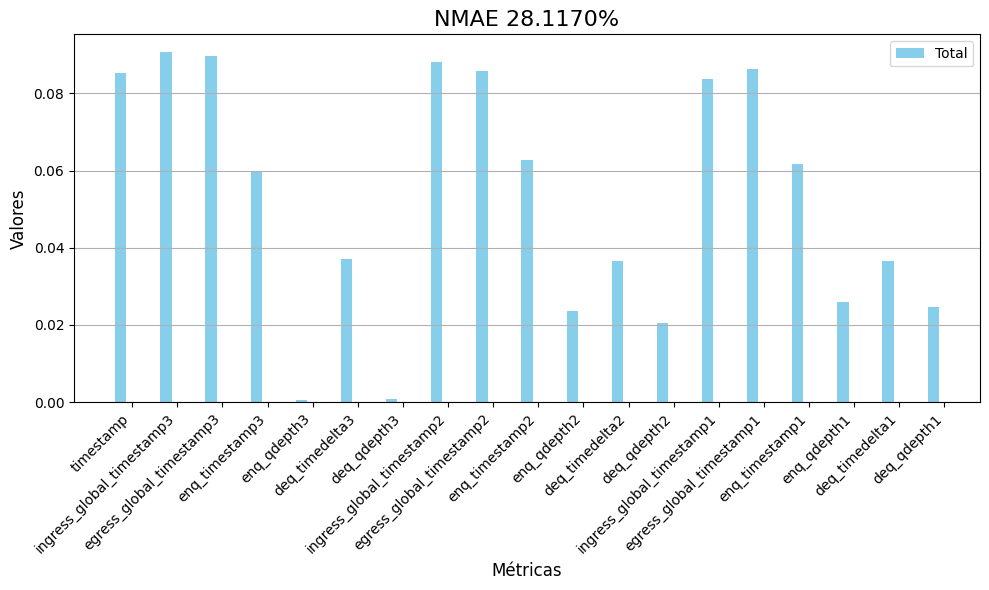

In [38]:
total = pred
labels = result_total.columns

x = np.arange(len(labels))

width = 0.25
plt.figure(figsize=(10, 6))
plt.bar(x - width, total, width, label='Total', color='skyblue')

plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.title(f'NMAE {nmae*100:.4f}%', fontsize=16)
plt.xticks(x, labels, rotation=45, ha='right')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
mae, nmae, model, pred = train_rf_model_gridsearch(result_total, labels)
print(f"{nmae*100:.4f}%")

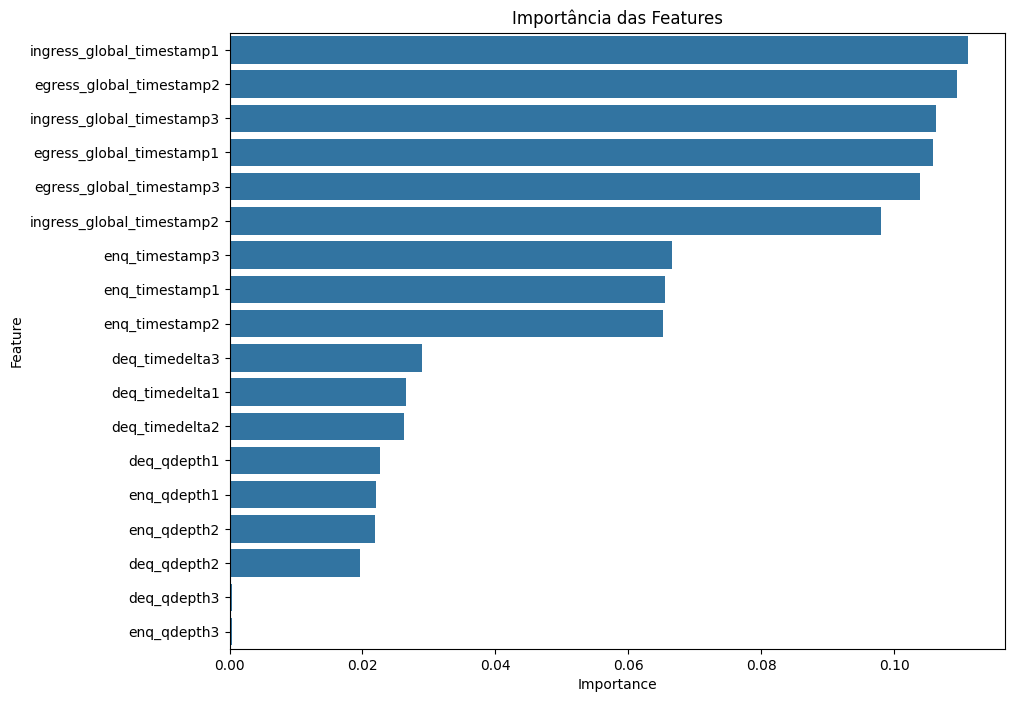

In [16]:
importances = model.feature_importances_
feature_names = result_total.columns
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Importância das Features')
plt.show()